In [ ]:
# ============================================
# Cell 1: Imports and Global Settings
# ============================================

import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Make results reproducible
np.random.seed(0)
random.seed(0)

# Make plots a bit bigger
plt.rcParams["figure.figsize"] = (8, 4)


In [ ]:
# ============================================
# Cell 2: Define Grid World Environment
# ============================================

# Grid size
ROWS, COLS = 8, 10

# Start and goal
START_STATE = (7, 0)   # bottom-left
GOAL_STATE  = (0, 9)   # top-right

# Obstacles
OBSTACLES = {
    (3, 3), (3, 4), (3, 5),
    (4, 5), (5, 5), (6, 5),
    (1, 7), (2, 7)
}

# Discount factor
GAMMA = 0.9

# Maximum steps per episode (for Monte Carlo)
MAX_STEPS = 500

# All valid states (skip obstacles)
STATES = [(r, c) for r in range(ROWS) for c in range(COLS)
          if (r, c) not in OBSTACLES]

# Actions: Up, Down, Left, Right (as row/col deltas)
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_NAMES = ["↑", "↓", "←", "→"]


def next_state_and_reward(state, action):
    """
    Given a state (r, c) and an action (dr, dc),
    return (next_state, reward).
    Deterministic transitions.
    """
    if state == GOAL_STATE:
        # Terminal: stays in goal with 0 reward
        return state, 0.0

    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc

    # Check boundaries and obstacles
    if nr < 0 or nr >= ROWS or nc < 0 or nc >= COLS or (nr, nc) in OBSTACLES:
        nr, nc = r, c  # stay in place if invalid move

    next_s = (nr, nc)

    if next_s == GOAL_STATE:
        # Reaching goal
        return next_s, 10.0
    else:
        # Step penalty
        return next_s, -1.0


def print_value_grid(V):
    """
    Pretty-print a state-value function V(s) as an 8x10 grid.
    Obstacles = '  X   ', goal = ' G:0.00 '
    """
    print("State-Value Grid (V):")
    for r in range(ROWS):
        row_str = ""
        for c in range(COLS):
            s = (r, c)
            if s in OBSTACLES:
                cell = "  X   "
            elif s == GOAL_STATE:
                cell = " G:0.0"
            else:
                val = V.get(s, 0.0)
                cell = f"{val:6.1f}"
            row_str += cell + " "
        print(row_str)
    print()


def print_policy_grid(policy):
    """
    Pretty-print a policy that maps state -> action_index
    using arrow symbols.
    Obstacles = 'X', goal = 'G'
    """
    print("Policy Grid:")
    for r in range(ROWS):
        row_str = ""
        for c in range(COLS):
            s = (r, c)
            if s in OBSTACLES:
                cell = "X"
            elif s == GOAL_STATE:
                cell = "G"
            else:
                a_idx = policy.get(s, None)
                if a_idx is None:
                    cell = "."
                else:
                    cell = ACTION_NAMES[a_idx]
            row_str += f"{cell:3s}"
        print(row_str)
    print()


In [ ]:
# ============================================
# Cell 3: Dynamic Programming (Value Iteration)
# ============================================

def value_iteration(theta=1e-4, gamma=GAMMA):
    """
    Perform Value Iteration for the grid world.
    Returns:
        V: dict mapping state -> value
        policy: dict mapping state -> best action index
    """
    # Initialize V(s) = 0
    V = {s: 0.0 for s in STATES}

    while True:
        delta = 0.0

        # Loop over all states
        for s in STATES:
            # Skip terminal state
            if s == GOAL_STATE:
                continue

            v_old = V[s]

            # Evaluate all actions
            q_vals = []
            for a_idx, a in enumerate(ACTIONS):
                ns, r = next_state_and_reward(s, a)
                q_val = r + gamma * V[ns]
                q_vals.append(q_val)

            # Bellman optimality update
            V[s] = max(q_vals)

            # Track maximum change
            delta = max(delta, abs(v_old - V[s]))

        # Convergence check
        if delta < theta:
            break

    # Derive greedy policy π*(s)
    policy = {}
    for s in STATES:
        if s == GOAL_STATE:
            continue
        q_vals = []
        for a_idx, a in enumerate(ACTIONS):
            ns, r = next_state_and_reward(s, a)
            q_val = r + gamma * V[ns]
            q_vals.append(q_val)
        best_a = int(np.argmax(q_vals))
        policy[s] = best_a

    return V, policy


# Run Value Iteration
V_dp, policy_dp = value_iteration()

# Show DP results
print("Dynamic Programming (Value Iteration) completed.\n")
print_value_grid(V_dp)
print_policy_grid(policy_dp)


Dynamic Programming (Value Iteration) completed.

State-Value Grid (V):
  -1.4   -0.4    0.6    1.8    3.1    4.6    6.2    8.0   10.0  G:0.0 
  -2.3   -1.4   -0.4    0.6    1.8    3.1    4.6   X       8.0   10.0 
  -3.0   -2.3   -1.4   -0.4    0.6    1.8    3.1   X       6.2    8.0 
  -3.7   -3.0   -2.3   X      X      X       1.8    3.1    4.6    6.2 
  -4.4   -3.7   -3.0   -3.7   -4.4   X       0.6    1.8    3.1    4.6 
  -4.9   -4.4   -3.7   -4.4   -4.9   X      -0.4    0.6    1.8    3.1 
  -5.4   -4.9   -4.4   -4.9   -4.4   X      -1.4   -0.4    0.6    1.8 
  -5.9   -5.4   -4.9   -4.4   -3.7   -3.0   -2.3   -1.4   -0.4    0.6 

Policy Grid:
→  →  →  →  →  →  →  →  →  G  
↑  ↑  ↑  ↑  ↑  ↑  ↑  X  ↑  ↑  
↑  ↑  ↑  ↑  ↑  ↑  ↑  X  ↑  ↑  
↑  ↑  ↑  X  X  X  ↑  →  ↑  ↑  
↑  ↑  ↑  ←  ←  X  ↑  ↑  ↑  ↑  
↑  ↑  ↑  ↑  ↑  X  ↑  ↑  ↑  ↑  
↑  ↑  ↑  ↑  ↓  X  ↑  ↑  ↑  ↑  
↑  ↑  ↑  →  →  →  ↑  ↑  ↑  ↑  



In [ ]:
# ============================================
# Cell 4: Monte Carlo Control (First-Visit, ε-Greedy)
# ============================================

# Monte Carlo hyperparameters
EPSILON = 0.2        # exploration rate
NUM_EPISODES = 2000  # total episodes

# Initialize Q(s, a) and visit counts N(s, a)
Q = {(s, a_idx): 0.0 for s in STATES for a_idx in range(len(ACTIONS))}
N = {(s, a_idx): 0   for s in STATES for a_idx in range(len(ACTIONS))}


def epsilon_greedy_action(state, epsilon=EPSILON):
    """
    Choose an action index using ε-greedy w.r.t. Q(s,a).
    """
    # With probability ε, explore random action
    if random.random() < epsilon:
        return random.randrange(len(ACTIONS))

    # Otherwise, choose greedy action (break ties randomly)
    q_vals = [Q[(state, a_idx)] for a_idx in range(len(ACTIONS))]
    max_q = max(q_vals)
    best_actions = [i for i, q in enumerate(q_vals) if q == max_q]
    return random.choice(best_actions)


In [ ]:
# ============================================
# Cell 5: Monte Carlo Training Loop + SSE Computation
# ============================================

steps_per_episode = []  # number of steps in each episode
sse_per_episode = []    # SSE(V_MC, V_DP) for each episode


for episode in range(NUM_EPISODES):
    # --------- Generate one episode ---------
    state = START_STATE
    episode_history = []  # list of (state, action_index, reward)

    for t in range(MAX_STEPS):
        # Choose action using ε-greedy policy derived from Q
        a_idx = epsilon_greedy_action(state, EPSILON)
        action = ACTIONS[a_idx]

        # Step in the environment
        next_state, reward = next_state_and_reward(state, action)

        # Store transition
        episode_history.append((state, a_idx, reward))

        state = next_state

        if state == GOAL_STATE:
            # Episode ends when goal is reached
            break

    # Track how many steps this episode took
    steps_per_episode.append(len(episode_history))

    # --------- First-Visit Monte Carlo Updates ---------
    G = 0.0
    visited = set()  # to enforce first-visit condition

    # Traverse episode backwards
    for t in reversed(range(len(episode_history))):
        s_t, a_t, r_t = episode_history[t]
        G = GAMMA * G + r_t

        if (s_t, a_t) not in visited:
            visited.add((s_t, a_t))
            key = (s_t, a_t)

            # Increment visit count
            N[key] += 1

            # Incremental mean to update Q(s,a)
            Q[key] += (G - Q[key]) / N[key]

    # --------- Compute V_MC(s) and SSE vs V_DP ---------
    V_mc = {}
    for s in STATES:
        # For each state, V_MC(s) = max_a Q(s,a)
        q_vals = [Q[(s, a_idx)] for a_idx in range(len(ACTIONS))]
        V_mc[s] = max(q_vals)

    # Sum of Squared Error between V_MC and V_DP
    sse = 0.0
    for s in STATES:
        if s == GOAL_STATE:
            continue  # skip terminal if you like
        diff = V_mc[s] - V_dp[s]
        sse += diff * diff

    sse_per_episode.append(sse)

    # (Optional) small print to see progress every 200 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode+1}/{NUM_EPISODES} completed. SSE = {sse:.2f}")

print("\nMonte Carlo training finished.")


Episode 500/2000 completed. SSE = 1416.57
Episode 1000/2000 completed. SSE = 1349.70
Episode 1500/2000 completed. SSE = 1335.98
Episode 2000/2000 completed. SSE = 1317.95

Monte Carlo training finished.


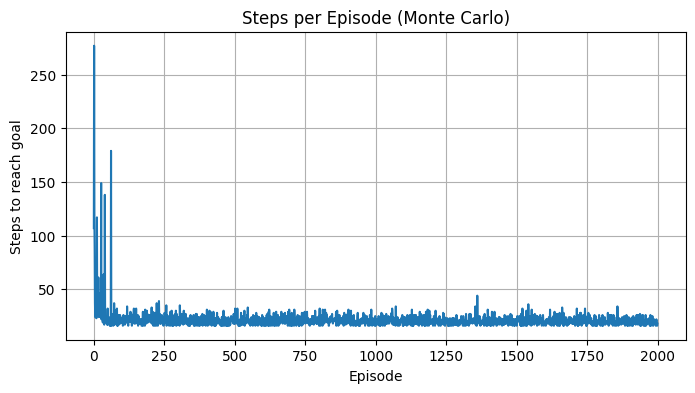

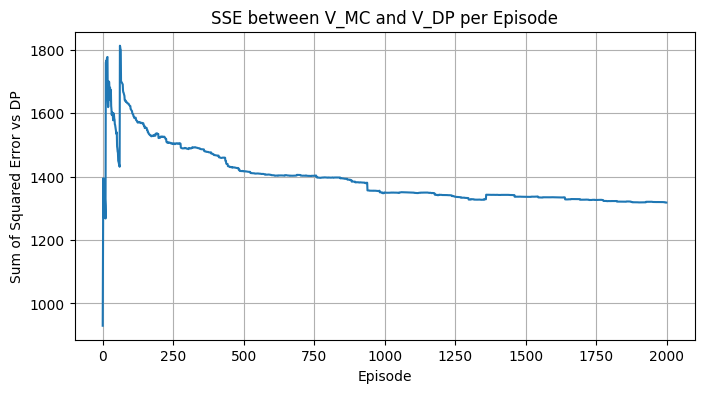

In [ ]:
# ============================================
# Cell 6: Plot Learning Curves (Steps & SSE)
# ============================================

# Steps per episode plot
plt.figure()
plt.plot(steps_per_episode)
plt.xlabel("Episode")
plt.ylabel("Steps to reach goal")
plt.title("Steps per Episode (Monte Carlo)")
plt.grid(True)
plt.show()

# SSE vs episode plot
plt.figure()
plt.plot(sse_per_episode)
plt.xlabel("Episode")
plt.ylabel("Sum of Squared Error vs DP")
plt.title("SSE between V_MC and V_DP per Episode")
plt.grid(True)
plt.show()


In [ ]:
# ============================================
# Cell 7: Inspect Final Monte Carlo Value Function & Policy
# ============================================

# Build final V_MC(s) from Q(s,a)
V_mc_final = {}
policy_mc = {}

for s in STATES:
    q_vals = [Q[(s, a_idx)] for a_idx in range(len(ACTIONS))]
    best_a = int(np.argmax(q_vals))
    V_mc_final[s] = q_vals[best_a]
    policy_mc[s] = best_a

print("Final Monte Carlo Value Function (V_MC):")
print_value_grid(V_mc_final)

print("Final Monte Carlo Policy (derived from Q):")
print_policy_grid(policy_mc)


Final Monte Carlo Value Function (V_MC):
State-Value Grid (V):
  -6.2   -3.3   -1.9   -0.5    1.5    3.5    5.6    7.7   10.0  G:0.0 
  -4.4   -3.5   -2.0   -1.0    0.4    1.9    3.6   X       7.7   10.0 
  -4.5   -3.8   -2.8   -1.8   -0.8    0.4    1.6   X       5.2    2.4 
  -5.2   -5.4   -3.7   X      X      X      -0.4   -3.4    0.0    0.6 
  -5.8   -5.2   -4.6   -5.4   -5.8   X      -1.5   -5.1   -3.7    0.0 
  -6.3   -6.0   -5.3   -5.9   -6.6   X      -6.7   -7.1   -8.3    0.0 
  -6.7   -6.5   -5.9   -6.3   -7.0   X      -9.2   -9.0   -9.2   -9.2 
  -7.3   -6.9   -6.4   -7.4   -8.4   -9.9   -9.9   -9.1   -9.5   -8.8 

Final Monte Carlo Policy (derived from Q):
Policy Grid:
→  →  →  →  →  →  →  →  →  G  
→  ↑  →  →  →  →  ↑  X  ↑  ↑  
→  →  →  →  →  ↑  ↑  X  ↑  ←  
↑  →  ↑  X  X  X  ↑  →  ↓  →  
↑  →  ↑  ←  ←  X  ↑  →  ←  ↑  
↑  →  ↑  ←  ←  X  ↑  ←  ←  ←  
↑  ↑  ↑  ↑  ↑  X  →  ↑  ↑  ↑  
→  ↑  ↑  ↑  ↑  ↓  ↑  ↑  →  ↓  

